In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [3]:
cd Desktop/Iowa_Liquor_Sales/

/Users/adrienpeltzer/Desktop/Iowa_Liquor_Sales


In [5]:
# Since our dataset has ~19M rows, let's start by loading just the first 100 rows and see what columns there are
df = pd.read_csv("Iowa_Liquor_Sales.csv",nrows=100)


In [8]:
[i for i in zip(range(len(df.columns)),df.columns.tolist())]

[(0, 'Invoice/Item Number'),
 (1, 'Date'),
 (2, 'Store Number'),
 (3, 'Store Name'),
 (4, 'Address'),
 (5, 'City'),
 (6, 'Zip Code'),
 (7, 'Store Location'),
 (8, 'County Number'),
 (9, 'County'),
 (10, 'Category'),
 (11, 'Category Name'),
 (12, 'Vendor Number'),
 (13, 'Vendor Name'),
 (14, 'Item Number'),
 (15, 'Item Description'),
 (16, 'Pack'),
 (17, 'Bottle Volume (ml)'),
 (18, 'State Bottle Cost'),
 (19, 'State Bottle Retail'),
 (20, 'Bottles Sold'),
 (21, 'Sale (Dollars)'),
 (22, 'Volume Sold (Liters)'),
 (23, 'Volume Sold (Gallons)')]

In [9]:
# There are 24 columns, but some of them can be inferred from the rest. For example, 
# the 'Volume Sold (Liters)' column is just "Bottles Sold" multiplied by "Bottle Volume (mL)"
# Clearly then, we shouldn't load the whole dataset 

In [10]:
# Let's find out what Categories of Liquor Sales there are: 
C = pd.read_csv("Iowa_Liquor_Sales.csv",usecols=[10,11])
C=C.dropna().drop_duplicates().reset_index(drop=True)


In [11]:
C.head()

,Category,Category Name
0,1032200.0,Imported Flavored Vodka
1,1012100.0,Canadian Whiskies
2,1012200.0,Scotch Whiskies
3,1032100.0,Imported Vodkas
4,1011400.0,Tennessee Whiskies


In [12]:
# We notice that the category codes are neatly grouped. If the code starts with "103", for example, then it is a Vodka. We use modular arithmetic to slice the frame:
lcodes={}

lcodes[101] = 'Whiskey'
lcodes[102] = 'Tequila'
lcodes[103] = 'Vodka'
lcodes[104] = 'Gin'
lcodes[105] = 'Brandies'
lcodes[106] = 'Rum'
lcodes[107] = "Cocktails"
lcodes[108] = "Liquers"
lcodes[109] = "Distilled Spirits"
lcodes[110] = ""
lcodes[150] = "High Proof Beer"
lcodes[170] = "Temporary and Specialty Packages"
lcodes[190] = "Special Order Items"

Vodka=C[C['Category'].apply(lambda x: x//10000)==103]
Whiskies=C[C['Category'].apply(lambda x: x//10000)==101]

In [13]:
Vodka.head(20)

,Category,Category Name
0,1032200.0,Imported Flavored Vodka
3,1032100.0,Imported Vodkas
6,1031100.0,American Vodkas
22,1031200.0,American Flavored Vodka
45,1031080.0,VODKA 80 PROOF
47,1031200.0,VODKA FLAVORED
55,1032080.0,IMPORTED VODKA
58,1031000.0,American Vodka
66,1032200.0,IMPORTED VODKA - MISC
67,1032000.0,Imported Vodka


In [14]:
# Even more, '1032' is imported vodka, '1031' is American vodka:
# We notice the fourth digit is 1 if its imported, 2 if its domestic, and 0 if its a special order item
# Let's load some more columns and do more exploratory analysis...

df = pd.read_csv("Iowa_Liquor_Sales.csv",usecols=[1,6,10,22],parse_dates=['Date'],date_parser=pd.to_datetime,infer_datetime_format=True)
df=df.dropna()
df['is_imported'] = (df.Category.apply(lambda x: str(x)[3] == '2')).astype(int)



/Users/adrienpeltzer/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [15]:
print(df['is_imported'].mean())

0.4211277705865148


In [16]:
# We see that about 42% of sales are of imported liquor, and this is consistent throughout the years:
print(df.groupby(df.Date.dt.year)['is_imported'].mean())

Date
2012    0.419857
2013    0.418968
2014    0.420526
2015    0.420487
2016    0.425664
2017    0.429249
2018    0.423080
2019    0.418872
2020    0.411866
Name: is_imported, dtype: float64


In [17]:
# Let's look at the top ten stores in terms of sales of liquour by volume.
df = pd.read_csv("Iowa_Liquor_Sales.csv",usecols=[1,2,22],parse_dates=['Date'],date_parser=pd.to_datetime,infer_datetime_format=True)


In [18]:
S=df['Store Number'].value_counts().head(10)
print(S)

2633    168336
4829    137875
2190    132943
2512    120184
2515    103677
2603    102936
2614    102554
2572    102553
2648     97442
2501     96805
Name: Store Number, dtype: int64


In [19]:
SS=df.groupby("Store Number")['Volume Sold (Liters)'].sum()
print(SS.sort_values(ascending = False).head(10))

Store Number
2633    5016658.23
4829    4094064.50
2512    2370292.65
3385    2205381.40
3420    2124792.70
3814    1762118.06
3354    1473726.15
3952    1447992.41
3494    1255362.15
2625    1193432.39
Name: Volume Sold (Liters), dtype: float64


In [20]:
# We see that, although Store 2190 sold the third most individual sales, it is not in the top ten in sales by volume
stores = S.sort_values(ascending = False).head(10).index.tolist()
print(stores)

[2633, 4829, 2190, 2512, 2515, 2603, 2614, 2572, 2648, 2501]


In [21]:
store = stores[0]
topstore=df[df['Store Number']==store]
# Let's look at how the top store fared over the years:
SS=topstore.groupby(topstore.Date.dt.year)['Volume Sold (Liters)'].sum()
print(SS)

Date
2012    540869.60
2013    533980.29
2014    562285.76
2015    582860.61
2016    607905.45
2017    616355.09
2018    621632.30
2019    635444.28
2020    315324.85
Name: Volume Sold (Liters), dtype: float64


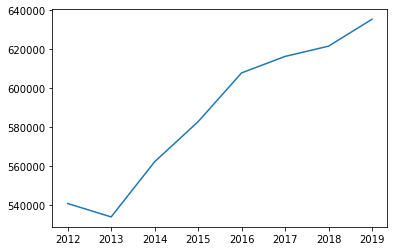

In [22]:
plt.figure()
plt.plot(SS.iloc[:-1])
plt.show(block=False)

In [ ]:
plt.close()

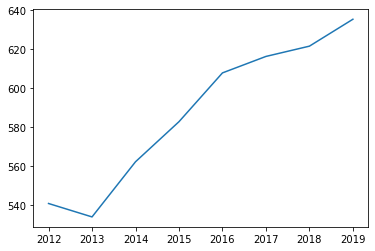

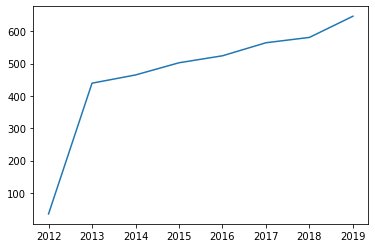

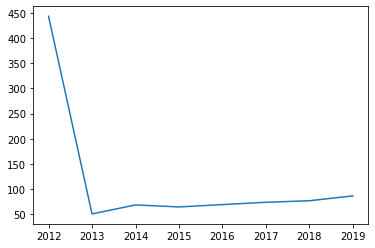

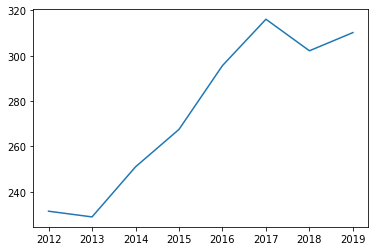

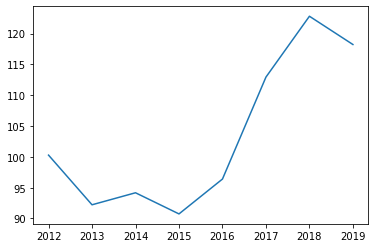

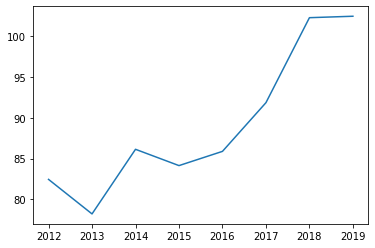

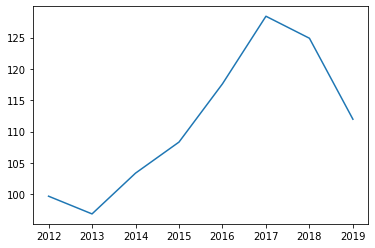

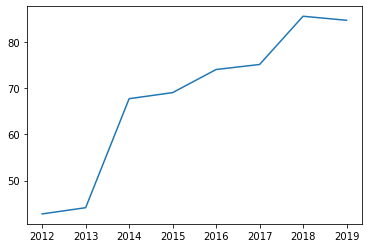

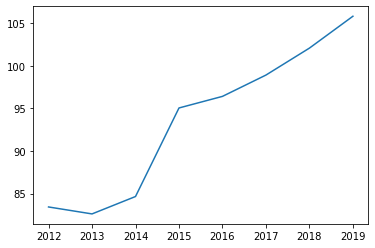

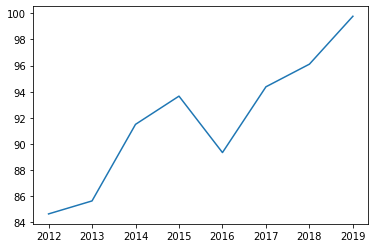

In [24]:
for store in stores:
    s=df[df['Store Number']==store]
    SS=s.groupby(s.Date.dt.year)['Volume Sold (Liters)'].sum()
    plt.figure()
    plt.plot(SS.iloc[:-1]/1000)
    plt.show(block=False)
    plt.close()

In [25]:
# The Sales vary drastically by store. Let's find the name of these stores.
Stores = pd.read_csv("Iowa_Liquor_Sales.csv",usecols = [2,3])

In [26]:
Stores = Stores.dropna()
Stores = Stores.groupby("Store Number").first()

In [27]:
Stores.loc[stores]

,Store Name
Store Number,
2633,Hy-Vee #3 / BDI / Des Moines
4829,Central City 2
2190,"Central City Liquor, Inc."
2512,Hy-Vee Wine and Spirits / Iowa City
2515,Hy-Vee Food Store #1 / Mason City
2603,Hy-Vee Wine and Spirits / Bettendorf
2614,Hy-Vee #3 Food & Drugstore / Davenport
2572,Hy-Vee Food Store / Cedar Falls
2648,Hy-Vee #4 / WDM


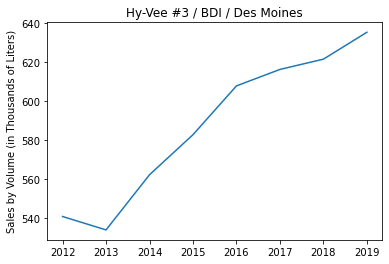

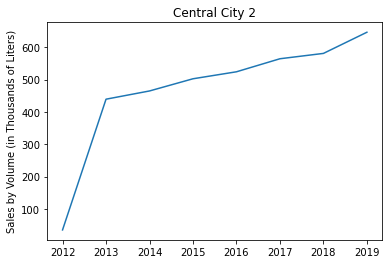

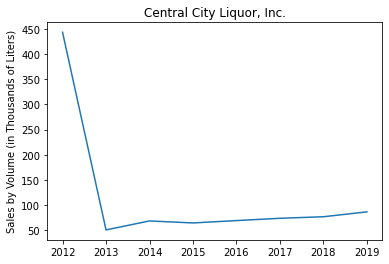

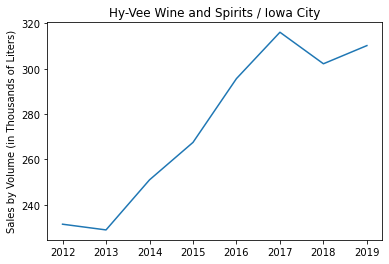

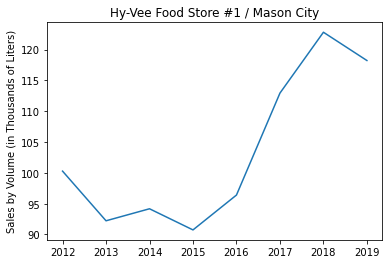

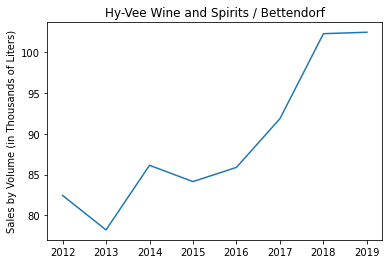

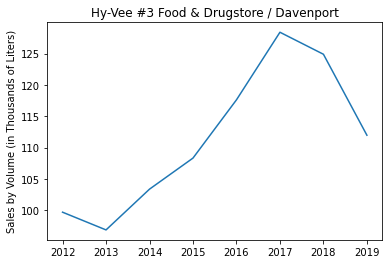

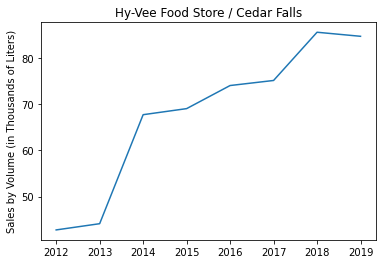

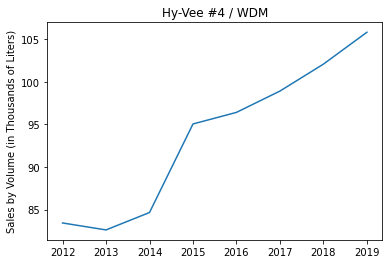

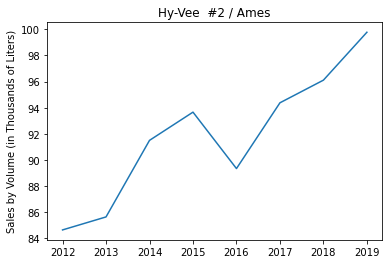

In [31]:
# lets redo the plots
for store in stores:
    s=df[df['Store Number']==store]
    SS=s.groupby(s.Date.dt.year)['Volume Sold (Liters)'].sum()
    plt.figure()
    sname = Stores.loc[store]
    plt.plot(SS.iloc[:-1]/1000)
    plt.title(sname.values[0])
    plt.ylabel("Sales by Volume (in Thousands of Liters)")
    plt.show(block=False)
    plt.close()

In [32]:
# Looking at Central City 2, and Central City Liquor, Inc., it looks like that is the same store, that just underwent a name change.

# Also, Hy-Vee seems to make the most sales. This is a supermarket.

In [33]:
# That's it for Exploratoy Analysis. We will continue later